# Data Cleaning & Preprocessing

This notebook prepares the Ames Housing dataset for modeling.
Steps:
1. Load data
2. Inspect missing values
3. Handle categorical/numerical features
4. Encode categorical features (with `get_dummies`)
5. Save cleaned datasets

In [1]:
import pandas as pd
import numpy as np

# Paths
train_path = "../data/train.csv"
test_path = "../data/test.csv"

# Load
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()

Train shape: (1460, 81)
Test shape: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Text(0.5, 1.0, 'SalePrice Distribution')

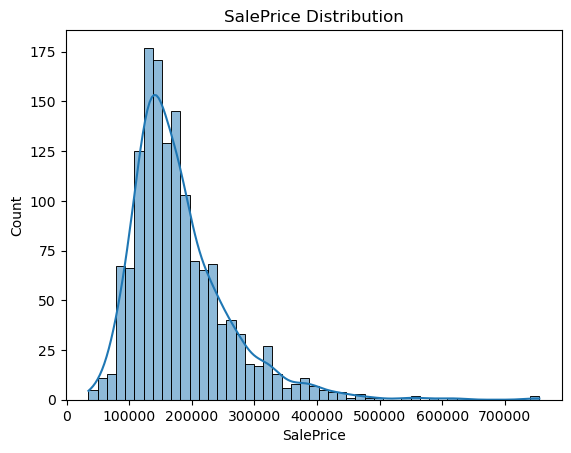

In [2]:
# Info + missing values
train.info()
train.isnull().sum().sort_values(ascending=False).head(20)

# Target distribution
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(train["SalePrice"], kde=True)
plt.title("SalePrice Distribution")

### Missing Value Strategy

- `LotFrontage`: fill with median by neighborhood (numeric).  
- `Alley`, `FireplaceQu`, `PoolQC`, `Fence`, `MiscFeature`, `Garage*`, `Bsmt*`:  
  NA means **“No such feature”** → replace with `"None"`.  
- `MasVnrArea`: fill with 0.  
- Categorical features with few missing (e.g., `Electrical`): fill with mode.  

In [3]:
# LotFrontage: fill with median by neighborhood
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median())
)

# Features where NA = "None"
none_features = [
    "Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2",
    "FireplaceQu","GarageType","GarageFinish","GarageQual","GarageCond",
    "PoolQC","Fence","MiscFeature"
]
for col in none_features:
    train[col] = train[col].fillna("None")
    test[col] = test[col].fillna("None")

# Masonry veneer
train["MasVnrArea"] = train["MasVnrArea"].fillna(0)
test["MasVnrArea"] = test["MasVnrArea"].fillna(0)
train["MasVnrType"] = train["MasVnrType"].fillna("None")
test["MasVnrType"] = test["MasVnrType"].fillna("None")

# Garage year: set to 0 if no garage
train["GarageYrBlt"] = train["GarageYrBlt"].fillna(0)
test["GarageYrBlt"] = test["GarageYrBlt"].fillna(0)

# Mode imputation for common categoricals
for col in ["Electrical","MSZoning","KitchenQual","Exterior1st","Exterior2nd","SaleType","Functional","Utilities"]:
    if train[col].isnull().sum() > 0:
        train[col] = train[col].fillna(train[col].mode()[0])
    if test[col].isnull().sum() > 0:
        test[col] = test[col].fillna(train[col].mode()[0])

# For numeric basement/garage values in test (rare single NAs): fill with 0
numeric_fill_0 = [
    "BsmtFullBath","BsmtHalfBath","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF",
    "TotalBsmtSF","GarageCars","GarageArea"
]
for col in numeric_fill_0:
    test[col] = test[col].fillna(0)


### Categorical Encoding

We’ll use **`pd.get_dummies`** for:
- Nominal features with no natural order (`MSZoning`, `Neighborhood`, `Exterior1st`, etc.)
- Binary categorical features (`Street`, `CentralAir`, etc.)

We’ll **NOT** one-hot encode ordinal fields (e.g., `OverallQual`, `ExterQual`, `KitchenQual`), since they have a ranking. We’ll map those to numeric scores.

In [4]:
# Example: quality mappings
qual_mapping = {
    "Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0
}

ordinal_features = ["ExterQual","ExterCond","BsmtQual","BsmtCond",
                    "HeatingQC","KitchenQual","FireplaceQu","GarageQual","GarageCond","PoolQC"]

for col in ordinal_features:
    train[col] = train[col].map(qual_mapping)
    test[col] = test[col].map(qual_mapping)


In [5]:
# Join train+test for consistent dummies
train["is_train"] = 1
test["is_train"] = 0
full = pd.concat([train, test], axis=0)

# One-hot encode selected categorical features
categorical = full.select_dtypes(include=["object"]).columns.drop(["SalePrice"], errors="ignore")

full = pd.get_dummies(full, columns=categorical, drop_first=True)

# Split back
train = full[full["is_train"]==1].drop("is_train", axis=1)
test = full[full["is_train"]==0].drop(["is_train","SalePrice"], axis=1)

In [6]:
# show remaining missing by column
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0].sort_values(ascending=False)
print("Remaining missing values in TRAIN:")
print(missing_train)

missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0].sort_values(ascending=False)
print("\nRemaining missing values in TEST:")
print(missing_test)


Remaining missing values in TRAIN:
Series([], dtype: int64)

Remaining missing values in TEST:
Series([], dtype: int64)


In [7]:
# Check missing values after cleaning
print("Missing values in cleaned train data:")
print(train.isnull().sum().sum())
print("\nMissing values in cleaned test data:")
print(test.isnull().sum().sum())

# Compare shapes before and after cleaning
print(f"\nOriginal train shape: {pd.read_csv(train_path).shape}")
print(f"Cleaned train shape: {train.shape}")
print(f"Original test shape: {pd.read_csv(test_path).shape}")
print(f"Cleaned test shape: {test.shape}")

# Check data types distribution
print(f"\nCleaned train data types:")
print(train.dtypes.value_counts())

# Sample of cleaned data
print(f"\nSample of cleaned train data:")
train.head()

Missing values in cleaned train data:
0

Missing values in cleaned test data:
0

Original train shape: (1460, 81)
Cleaned train shape: (1460, 231)
Original test shape: (1459, 80)
Cleaned test shape: (1459, 230)

Cleaned train data types:
bool       183
int64       36
float64     12
Name: count, dtype: int64

Sample of cleaned train data:


,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,60,65.0,8450,7,5,2003,2003,196.0,4,...,False,False,False,False,True,False,False,False,True,False
1,2,20,80.0,9600,6,8,1976,1976,0.0,3,...,False,False,False,False,True,False,False,False,True,False
2,3,60,68.0,11250,7,5,2001,2002,162.0,4,...,False,False,False,False,True,False,False,False,True,False
3,4,70,60.0,9550,7,5,1915,1970,0.0,3,...,False,False,False,False,True,False,False,False,False,False
4,5,60,84.0,14260,8,5,2000,2000,350.0,4,...,False,False,False,False,True,False,False,False,True,False


In [8]:
import os

# Create the cleaned_data directory if it doesn't exist
os.makedirs("../cleaned_data", exist_ok=True)

# Save the cleaned datasets
train.to_csv("../cleaned_data/train_clean.csv", index=False)
test.to_csv("../cleaned_data/test_clean.csv", index=False)

print("Cleaned datasets saved successfully!")
print(f"Train data saved to: ../cleaned_data/train_clean.csv")
print(f"Test data saved to: ../cleaned_data/test_clean.csv")

Cleaned datasets saved successfully!
Train data saved to: ../cleaned_data/train_clean.csv
Test data saved to: ../cleaned_data/test_clean.csv
